In [11]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

import torch

from data import transforms as T
from common.subsample import create_mask_for_mask_type


In [3]:
%pwd

'/Users/yg/code/github/fastMRI'

In [7]:
def apply_mask(device, mask_func, kspace, seed=None):
    """
    Subsample given k-space by multiplying with a mask.

    Args:
        kspace (torch.Tensor): The input k-space data. This should have at least 3 dimensions, where
            dimensions -3 and -2 are the spatial dimensions, and the final dimension has size
            2 (for complex values).
        mask_func (callable): A function that takes a shape (tuple of ints) and a random
            number seed and returns a mask.
        seed (int or 1-d array_like, optional): Seed for the random number generator.

    Returns:
        (tuple): tuple containing:
            masked data (torch.Tensor): Subsampled k-space data
            mask (torch.Tensor): The generated mask
    """
    shape = np.array(kspace.shape)
    shape[:-3] = 1
    mask = mask_func(shape, seed)
    mask = mask.to(device)
    kspace = kspace.to(device)
    return torch.where(mask == 0, torch.Tensor([0]).to(device), kspace), mask


def resize(hparams, image, target):
    smallest_width = min(hparams.resolution, image.shape[-2])
    smallest_height = min(hparams.resolution, image.shape[-3])
    if target is not None:
        smallest_width = min(smallest_width, target.shape[-1])
        smallest_height = min(smallest_height, target.shape[-2])
    crop_size = (smallest_height, smallest_width)
    image = T.complex_center_crop(image, crop_size)
    # Absolute value
    image_abs = T.complex_abs(image)
    # Apply Root-Sum-of-Squares if multicoil data
    if hparams.challenge == "multicoil":
        image_abs = T.root_sum_of_squares(image_abs)
    # Normalize input
    image_abs, mean, std = T.normalize_instance(image_abs, eps=1e-11)
    image_abs = image_abs.clamp(-6, 6)

    # Normalize target
    if target is not None:
        target = T.to_tensor(target)
        target = T.center_crop(target, crop_size)
        target = T.normalize(target, mean, std, eps=1e-11)
        target = target.clamp(-6, 6)
    else:
        target = torch.Tensor([0])
    return image, image_abs, target, mean, std


def forward_adjoint_helper(device, hparams, mask_func, kspace, target=None):
    masked_kspace, _ = apply_mask(device, mask_func, kspace, hparams.seed)
    if not torch.is_tensor(masked_kspace):
        kspace_tensor = T.to_tensor(masked_kspace)
    else:
        kspace_tensor = masked_kspace
    image = transforms.ifft2(kspace_tensor)
    image, image_abs, _, _, _ = resize(hparams, image, target)
    return image, image_abs


def X_operator(img):
    fft2 =T.fft2(img)
    print(fft2.shape)
    return fft2

In [13]:
hparams = {"resolution": 320, 
           "challenge":"singlecoil", "mask-type": "equispaced", 
           "accelerations":[4, 8], "center_fractions": [0.08, 0.04]}

In [15]:
mask = create_mask_for_mask_type(hparams["mask-type"],  hparams["center_fractions"], hparams["accelerations"])

In [4]:
file = "data/singlecoil_train/file1000001.h5"
hf = h5py.File(file, "r")

In [5]:
kspaces =hf['kspace']

In [16]:
device="cpu"

In [30]:
svds = np.zeros((len(kspaces), 372))
for i in range(len(kspaces)):
    kspace = kspaces[i]
    kspace = T.to_tensor(kspace)
    # forward_adjoint_helper(device, hparams, mask, kspace)
    masked_kspace, _ = apply_mask(device, mask, kspace,42)
    u,s,v = np.linalg.svd(masked_kspace[:,:,0])
    svds[i,:] = s

In [49]:
svds[0,:50]

array([0.00037652, 0.00027777, 0.00025282, 0.00024386, 0.00024282,
       0.00024128, 0.00023925, 0.00023331, 0.00022785, 0.00022727,
       0.00022598, 0.00022579, 0.00022371, 0.0002222 , 0.00022079,
       0.00021848, 0.00021714, 0.00021584, 0.00021487, 0.00021085,
       0.0002089 , 0.0002079 , 0.00020651, 0.0002051 , 0.00020364,
       0.00020275, 0.00020182, 0.0001994 , 0.00019765, 0.00019587,
       0.00019556, 0.00019275, 0.00019223, 0.0001917 , 0.0001914 ,
       0.00018898, 0.00018807, 0.00018576, 0.00018348, 0.00018197,
       0.0001814 , 0.00018061, 0.00017938, 0.00017669, 0.00017604,
       0.00017535, 0.00017327, 0.00017211, 0.00017157, 0.00017078])

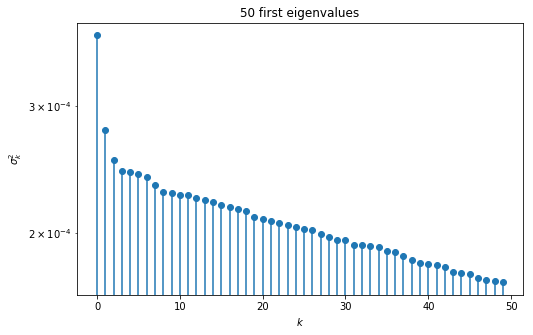

In [50]:
fig, ax = plt.subplots(figsize=(8,5))
#for i in range(svds.shape[0]):
x = np.arange(svds[0,:].shape[0]) 
plt.stem(svds[0,:50]) 
plt.title("50 first eigenvalues")
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$\sigma_k^2$')
plt.savefig('variance_plot_log.pdf', bbox_inches='tight')
plt.show()

In [ ]:
 plt.stem(eigvals[0: 100], use_line_collection = True) # plt.xlim([0, 100])
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$\sigma_k^2$') plt.savefig('variance_plot_log.pdf', bbox_inches='tight')